In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import Activation, Flatten, Dropout
from keras.optimizers import SGD
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [4]:
train_cols = ["Precipitation","Temperature","Outflow"]

In [5]:
new_df = df.filter(train_cols, axis=1)

In [6]:
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Precipitation(t+%d)' %(i+1)] = new_df['Precipitation'].shift(-(i+1))
        df['Temperature(t+%d)' %(i+1)] = new_df['Temperature'].shift(-(i+1))
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

In [7]:
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    output_size_1 = Y.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,output_size_1))
    Y_values_actual = np.zeros((input_size_0,output_size_1))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1]
        Y_values_actual[i] = Y_actual[time_steps+i-1]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [8]:
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)

In [9]:
lag_df

,Precipitation,Temperature,Outflow,Precipitation(t+1),Temperature(t+1),Outflow(t+1)
0,0.0,102.992,5.0,0.0,97.790,5.0
1,0.0,97.790,5.0,0.0,92.588,5.0
2,0.0,92.588,5.0,0.0,87.404,5.0
3,0.0,87.404,5.0,0.0,85.172,5.0
4,0.0,85.172,5.0,0.0,82.940,5.0
...,...,...,...,...,...,...
185538,0.0,52.880,29.0,0.0,54.284,30.0
185539,0.0,54.284,30.0,0.0,55.670,29.0
185540,0.0,55.670,29.0,0.0,57.074,29.0
185541,0.0,57.074,29.0,0.0,57.056,31.0


In [10]:
#label_cols = ["Outflow(t+1)", "Outflow(t+2)", "Outflow(t+3)"]
label_cols = ['Precipitation(t+1)','Temperature(t+1)','Outflow(t+1)']

In [11]:
#Min Max scalr normalizing
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [12]:
#Splitting training and test data
df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
x_train = df_train.loc[:,train_cols].values
y_train = df_train.loc[:,label_cols].values
x_test = df_test.loc[:,train_cols].values
y_test = df_test.loc[:,label_cols].values

In [13]:
x_train.shape, y_test.shape

((148434, 3), (37109, 3))

In [14]:
y_train_actual = y_train
y_test_actual = y_test

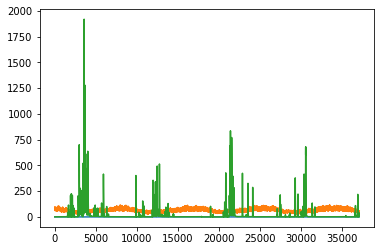

In [15]:
plt.figure()
plt.plot(y_test_actual)
plt.show()

In [16]:
#Normalizing training data
x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

# Normalizing test data
x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
y_test_nor = ytest_min_max_scaler.fit_transform(y_test)

In [17]:
#Building timeseries
X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (148416, 18, 3) (148416, 3)



length of time-series i/o (37091, 18, 3) (37091, 3)


In [18]:
Y_Train

array([[0.00000000e+00, 7.70701820e-01, 2.21729490e-03],
       [0.00000000e+00, 8.09134794e-01, 2.21729490e-03],
       [0.00000000e+00, 8.47567768e-01, 2.21729490e-03],
       ...,
       [0.00000000e+00, 5.31934645e-01, 5.54323725e-04],
       [0.00000000e+00, 5.81507612e-01, 5.54323725e-04],
       [0.00000000e+00, 6.30894913e-01, 5.54323725e-04]])

In [19]:
X_Train.shape,Y_Train.shape

((148416, 18, 3), (148416, 3))

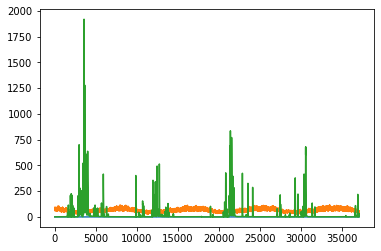

In [20]:
plt.figure()
plt.plot(Y_test_actual)
plt.show()

In [21]:
#Build Model
model = Sequential()
model.add(LSTM(units=24, return_sequences=True, 
               input_shape=(X_Train.shape[1],X_Train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))

model.add(Dense(3, activation='linear'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 18, 24)            2688      
_________________________________________________________________
dropout (Dropout)            (None, 18, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                15000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 63        
Total params: 18,771
Trainable params: 18,771
Non-trainable params: 0
____________________________________________________

In [22]:
history = model.fit(X_Train, Y_Train, epochs=10,
                   validation_data=(X_Test, Y_Test))

Epoch 1/10
4638/4638 [==============================] - 41s 9ms/step - loss: 0.0010 - val_loss: 2.1671e-04
Epoch 2/10
4638/4638 [==============================] - 53s 11ms/step - loss: 2.2025e-04 - val_loss: 1.3850e-04
Epoch 3/10
4638/4638 [==============================] - 39s 8ms/step - loss: 1.8038e-04 - val_loss: 2.6742e-04
Epoch 4/10
4638/4638 [==============================] - 38s 8ms/step - loss: 1.5086e-04 - val_loss: 4.0590e-04
Epoch 5/10
4638/4638 [==============================] - 39s 8ms/step - loss: 1.3756e-04 - val_loss: 4.3586e-04
Epoch 6/10
4638/4638 [==============================] - 45s 10ms/step - loss: 1.2951e-04 - val_loss: 8.0342e-04
Epoch 7/10
4638/4638 [==============================] - 45s 10ms/step - loss: 1.2474e-04 - val_loss: 0.0010
Epoch 8/10
4638/4638 [==============================] - 49s 11ms/step - loss: 1.1860e-04 - val_loss: 0.0011
Epoch 9/10
4638/4638 [==============================] - 45s 10ms/step - loss: 1.1274e-04 - val_loss: 0.0012
Epoch 10/10


In [23]:
weights = model.get_weights()

In [24]:
len(weights)

10

In [25]:
[weights[i].shape for i in range(len(weights))]

[(3, 96),
 (24, 96),
 (96,),
 (24, 200),
 (50, 200),
 (200,),
 (50, 20),
 (20,),
 (20, 3),
 (3,)]

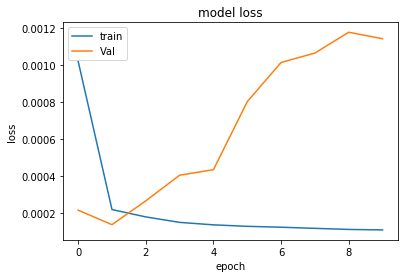

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [27]:
#model.save("model1_waterflow_mse_32.hdf5")

In [28]:
predicted_y_values = model.predict(X_Test)

In [29]:
predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)

In [30]:
predicted_y_values_unnor[20],predicted_y_values_unnor[2000]

(array([3.4410256e-04, 6.0154392e+01, 2.7010655e+00], dtype=float32),
 array([1.5667029e-02, 5.3121971e+01, 1.1032285e+02], dtype=float32))

In [31]:
#max(predicted_y_values_unnor)
outflow = []
l1 = len(predicted_y_values_unnor)
for each_array in predicted_y_values_unnor:
    outflow.append(each_array[2])
max(outflow)

1651.3627

In [32]:
#len(Y_test_actual)
outflow_actual = []
l1 = len(Y_test_actual)
for each_array in Y_test_actual:
    outflow_actual.append(each_array[2])
max(outflow_actual)

1920.0

In [33]:
Y_test_actual[200:205]

array([[ 0.   , 81.716,  1.   ],
       [ 0.   , 84.254,  1.   ],
       [ 0.   , 84.398,  1.   ],
       [ 0.   , 84.56 ,  1.   ],
       [ 0.   , 84.704,  1.   ]])

In [32]:
#y_train_predict = model.predict(X_Train)
#predicted_y_train_unnor = ytrain_min_max_scaler.inverse_transform(y_train_predict)

In [35]:
l = len(predicted_y_values_unnor)
acc = sum([outflow[i]==outflow_actual[i] for i in range(l)])/l
acc

0.0

In [36]:
mean_square_root = mean_squared_error(outflow, outflow_actual)
mean_square_root

107.33103239299149

In [37]:
predicted_y_values_unnor

array([[ 2.9636154e-04,  5.4994411e+01,  1.9845440e+00],
       [ 2.6432946e-04,  5.5365429e+01,  1.4473873e+00],
       [-2.6450027e-04,  5.6376122e+01,  1.1788527e+00],
       ...,
       [-3.8734733e-04,  4.8202385e+01,  5.9351468e+00],
       [-6.6167512e-04,  4.9131176e+01,  1.1484433e+01],
       [ 7.4269628e-04,  4.9567226e+01,  1.2237888e+01]], dtype=float32)

In [38]:
len(predicted_y_values_unnor)

37091

In [39]:
y_train_predict = model.predict(X_Train)
predicted_y_train_unnor = ytrain_min_max_scaler.inverse_transform(y_train_predict)

In [40]:
len(predicted_y_train_unnor)

148416

In [41]:
len(Y_Train)

148416

In [42]:
len(predicted_y_train_unnor)

148416

In [43]:
y_train_predict.shape

(148416, 3)

In [49]:
y_train_predict[5000][2]

0.0017340702

In [53]:
def timeseries1(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

In [79]:
#for model2
#Building timeseries
X_Train1, Y_Train1, Y_train_actual1 = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=19, out_steps=1)
X_Test1, Y_Test1, Y_test_actual1 = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=19, out_steps=1)

/home/bidur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



length of time-series i/o (148415, 19, 3) (148415, 3)



length of time-series i/o (37090, 19, 3) (37090, 3)


In [80]:
#replacing last value of each timeseries data with the predicted value
len_data = len(X_Train1)

In [81]:
for i in range (len_data):
    X_Train1[i][18][0] = y_train_predict[i][0]
    X_Train1[i][18][1] = y_train_predict[i][1]
    X_Train1[i][18][2] = y_train_predict[i][2]

In [82]:
#Build Model for second model 
model1 = Sequential()
model1.add(LSTM(units=24, return_sequences=True, 
               input_shape=(X_Train1.shape[1],X_Train1.shape[2])))
model1.add(Dropout(0.2))

model1.add(LSTM(units=50))
model1.add(Dropout(0.2))

model1.add(Dense(20, activation='relu'))

model1.add(Dense(3, activation='linear'))

model1.compile(optimizer = 'adam', loss = 'mean_squared_error')

model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 19, 24)            2688      
_________________________________________________________________
dropout_6 (Dropout)          (None, 19, 24)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                15000     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 63        
Total params: 18,771
Trainable params: 18,771
Non-trainable params: 0
__________________________________________________

In [83]:
predicted_y_values.shape

(37091, 3)

In [84]:
len_data

148415

In [85]:
len_data_test = len(X_Test1)
for i in range (len_data_test):
    X_Test1[i][18][0] = predicted_y_values[i][0]
    X_Test1[i][18][1] = predicted_y_values[i][1]
    X_Test1[i][18][2] = predicted_y_values[i][2]

In [86]:
history = model1.fit(X_Train1, Y_Train1, epochs=10,
                   validation_data=(X_Test1, Y_Test1))

Epoch 1/10
4638/4638 [==============================] - 54s 12ms/step - loss: 9.4743e-04 - val_loss: 2.6553e-04
Epoch 2/10
4638/4638 [==============================] - 57s 12ms/step - loss: 2.8038e-04 - val_loss: 2.6231e-04
Epoch 3/10
4638/4638 [==============================] - 57s 12ms/step - loss: 2.5258e-04 - val_loss: 2.0090e-04
Epoch 4/10
4638/4638 [==============================] - 57s 12ms/step - loss: 2.3940e-04 - val_loss: 2.1719e-04
Epoch 5/10
4638/4638 [==============================] - 59s 13ms/step - loss: 2.2417e-04 - val_loss: 2.0497e-04
Epoch 6/10
4638/4638 [==============================] - 57s 12ms/step - loss: 2.0948e-04 - val_loss: 3.7875e-04
Epoch 7/10
4638/4638 [==============================] - 57s 12ms/step - loss: 1.9080e-04 - val_loss: 5.8973e-04
Epoch 8/10
4638/4638 [==============================] - 57s 12ms/step - loss: 1.8175e-04 - val_loss: 5.9820e-04
Epoch 9/10
4638/4638 [==============================] - 58s 12ms/step - loss: 1.7394e-04 - val_loss: 7.4

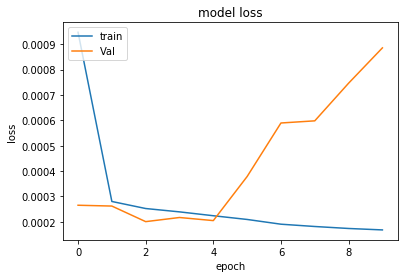

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Val'], loc='upper left')
plt.show()

In [88]:
predicted_y_values1 = model1.predict(X_Test1)

In [89]:
predicted_y_values1.shape

(37090, 3)

In [90]:
predicted_y_values1_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values1)

In [91]:
#max(predicted_y_values_unnor)
outflow1 = []
l1 = len(predicted_y_values1_unnor)
for each_array in predicted_y_values1_unnor:
    outflow1.append(each_array[2])
max(outflow)

1651.3627

In [92]:
max(outflow1)

2107.6355

In [93]:
#len(Y_test_actual)
outflow1_actual = []
l1 = len(Y_test_actual1)
for each_array in Y_test_actual1:
    outflow1_actual.append(each_array[2])
max(outflow1_actual)

1920.0

In [94]:
mean_square_root = mean_squared_error(outflow1, outflow1_actual)
mean_square_root

184.90776758460711